# DQN

## libraries and data

In [ ]:
# from google.colab import drive
import sys, os
# import atari_py

#mount google drive
# drive.mount('/content/drive', force_remount=False)
cwd = os.getcwd()

In [ ]:
%%capture
os.chdir(cwd+"/common")
!python3 -m atari_py.import_roms ../Roms
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Algorithm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import gym
import numpy as np

import math, random
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

/home/zhanghao/.local/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()



In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Environment and parameter

In [ ]:
seed = 2022
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed_all(seed)

env_id = "Breakout-v4"
env = gym.make(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 1400000
batch_size = 32
gamma      = 0.99



/home/zhanghao/.local/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Breakout-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Breakout-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


### display epsilon over training

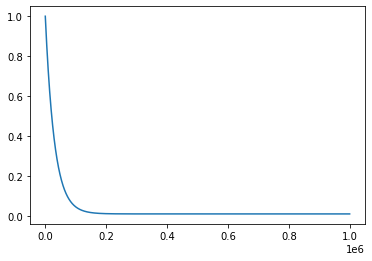

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

### Deep Q Network

In [ ]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0)
            state = state.cuda()
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

    def eval(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.cuda()
        q_value = self.forward(state)
        action  = q_value.max(1)[1].data[0]
   
        return action

### Replay Buffer

In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)

if torch.cuda.is_available():
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0002)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

### Compute Loss

In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value  * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

### plot function

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

### training

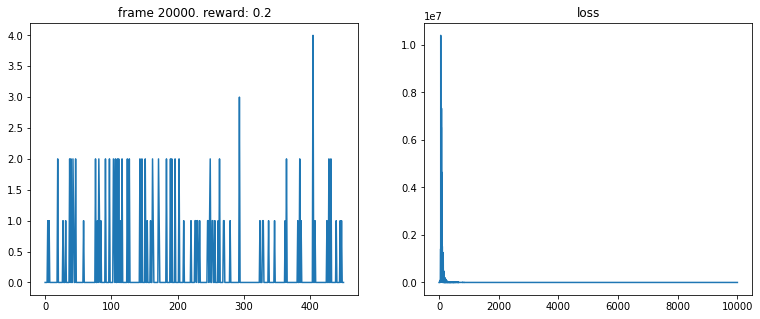

KeyboardInterrupt: 

In [ ]:
losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)




### Save Model

In [ ]:
torch.save(model.state_dict(),cwd+"/models/dqn.pt")

### Test with Model

In [1]:
"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from gym.wrappers import Monitor
import glob, io, base64


# monitor_logger = logging.getLogger()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
    

def wrap_env(env):
    display = Display(visible=0, size=(1400, 900))
    display.start()
    env = Monitor(env, './video/dqn', force=True)
    return env




model = CnnDQN(env.observation_space.shape, env.action_space.n)
if torch.cuda.is_available():
    model = model.cuda()

model.load_state_dict(torch.load(cwd+"/models/dqn.pt"))


gym_only_env = wrap_env(gym.make(env_id))
gym_only_env = wrap_deepmind(gym_only_env)
gym_only_env = wrap_pytorch(gym_only_env)

observation = gym_only_env.reset()

while True:

    action = model.eval(observation)

    observation, reward, done, info = gym_only_env.step(action) 
                
    if done: 
        break
            
gym_only_env.close()
# show_video()